In [1]:
import pandas
import sys
import warnings
import ee
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
# import local modules
sys.path.append('../src')
from Fishnet import Fishnet
from ImageExporter import ImageExporter
from ImageCorrector import ImageCorrector
from ImageProcessor import ImageProcessor

# update files automatically
%load_ext autoreload
%autoreload 2
pandas.set_option('display.max_columns', 500)

In [3]:
from custom_dataset import CustomDataset
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import torch.nn as nn
import torch.optim as optim

# Load complete Fishnet

In [4]:
fc = Fishnet.load('../Gis/Fishnet/fishnet_quarter_mile_completed.pkl')

In [5]:
# Compute Urbanization Rate
for year in [2017, 2018, 2019, 2020, 2021, 2022]:
    fc.compute_difference(f'MeanPixel_{year}', f'MeanPixel_{year-1}', filtered=True, normalize = True)

fc.filtered_fishnet.rename(columns={'MeanPixel_2022-MeanPixel_2021': 'UrbanizationRate2022'}, inplace=True)
fc.filtered_fishnet.rename(columns={'MeanPixel_2021-MeanPixel_2020': 'UrbanizationRate2021'}, inplace=True)
fc.filtered_fishnet.rename(columns={'MeanPixel_2020-MeanPixel_2019': 'UrbanizationRate2020'}, inplace=True)
fc.filtered_fishnet.rename(columns={'MeanPixel_2019-MeanPixel_2018': 'UrbanizationRate2019'}, inplace=True)
fc.filtered_fishnet.rename(columns={'MeanPixel_2018-MeanPixel_2017': 'UrbanizationRate2018'}, inplace=True)
fc.filtered_fishnet.rename(columns={'MeanPixel_2017-MeanPixel_2016': 'UrbanizationRate2017'}, inplace=True)
fc.filtered_fishnet.drop(columns=['MeanPixel_2021-MeanPixel_2016'], inplace=True)

In [6]:
fc.filtered_fishnet.head(3)

,id,geometry,batch_id,neighbors,ImageCoordinates,Width,Height,MeanPixel_2016,Entropy_2016,MeanPixel_2017,Entropy_2017,MeanPixel_2018,Entropy_2018,MeanPixel_2019,Entropy_2019,MeanPixel_2020,Entropy_2020,MeanPixel_2021,Entropy_2021,MeanPixel_2022,Entropy_2022,UrbanizationRate2017,UrbanizationRate2018,UrbanizationRate2019,UrbanizationRate2020,UrbanizationRate2021,UrbanizationRate2022
6060154,6060154.0,"POLYGON ((-95.79985 29.79208, -95.79985 29.795...",23743.0,"[6056884, 6056885, 6056886, 6060153, 6060155, ...","(403, 524, 448, 564)",45.0,40.0,181.191667,0.868003,197.341667,0.771170,222.275000,0.552850,219.583333,0.581321,225.958333,0.511536,233.041667,0.423354,237.008333,0.367993,0.063333,0.097778,-0.010556,0.025000,0.027778,0.015556
6060155,6060155.0,"POLYGON ((-95.79583 29.79208, -95.79583 29.795...",23743.0,"[6056885, 6056886, 6056887, 6060154, 6060156, ...","(448, 524, 492, 564)",44.0,40.0,204.724432,0.716210,213.272727,0.642938,229.355114,0.470794,228.485795,0.481478,230.948864,0.450721,237.613636,0.359102,241.815341,0.293594,0.033523,0.063068,-0.003409,0.009659,0.026136,0.016477
6060156,6060156.0,"POLYGON ((-95.79181 29.79208, -95.79181 29.795...",23743.0,"[6056886, 6056887, 6056888, 6060155, 6060157, ...","(492, 524, 537, 564)",45.0,40.0,140.250000,0.992774,133.025000,0.998645,136.708333,0.996234,147.333333,0.982474,148.750000,0.979869,168.583333,0.923751,168.583333,0.923751,-0.028333,0.014444,0.041667,0.005556,0.077778,0.000000


# Which image size do we want?

Text(0.5, 0, 'Height (pixels)')

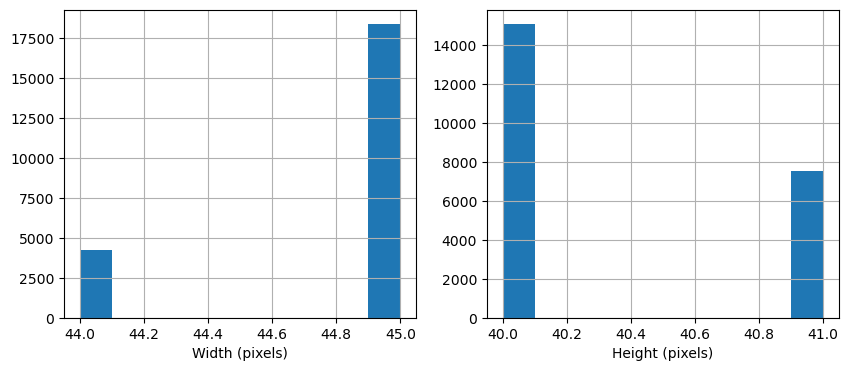

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(121)
fc.filtered_fishnet["Width"].hist()
plt.xlabel('Width (pixels)')
plt.subplot(122)
fc.filtered_fishnet["Height"].hist()
plt.xlabel('Height (pixels)')

# Export batch images into smaller images and store them locally

In [8]:
if False:
    img_process = ImageProcessor(
        fc,
        filtered=True,
        )

    for year in tqdm([2016, 2017, 2018, 2019, 2020, 2021, 2022]):
        img_process.cnn_partition_images(
            image_folder="../Images2/",
            file_name="landcover_batchID",
            year=year,
            img_size=[40, 44],
            warning=False,
            show_progress=False,
        )

# Convolutional Neural Network

Train a CNN to predict next year urbanization based on single image

In [9]:
vars = ["id", "batch_id", "UrbanizationRate2017", "UrbanizationRate2018", "UrbanizationRate2019", "UrbanizationRate2020", "UrbanizationRate2021", "UrbanizationRate2022"]
data = fc.filtered_fishnet[vars]
data.rename(columns={"id": "tile_id"}, inplace=True)
data["tile_id"] = data["tile_id"].astype(int)
data["batch_id"] = data["batch_id"].astype(int)

# Pivot wide to long
data = data.melt(id_vars=["tile_id", "batch_id"], var_name="year", value_name="urbanization_rate")
data["year"] = data["year"].str[-4:]
data.head()

,tile_id,batch_id,year,urbanization_rate
0,6060154,23743,2017,0.063333
1,6060155,23743,2017,0.033523
2,6060156,23743,2017,-0.028333
3,6060157,23743,2017,-0.052778
4,6060158,23743,2017,0.006667


# Train / Test Split

In [10]:
# Split dataset into training and test subsets
test_ratio = 0.1 
val_ratio = 0.1
train_val_data, test_data = train_test_split(data, test_size=test_ratio, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=val_ratio, random_state=42)

# Create DataLoaders for training and test sets
base_path = "../Images2/CNN"    
train_data = CustomDataset(base_path, train_data)
val_data = CustomDataset(base_path, val_data)
test_data = CustomDataset(base_path, test_data)

batch_size = 64    # Adjust according to your available resources
shuffle = True     # Set to True if you want to shuffle the dataset during training
num_workers = 1    # Number of worker threads for data loading

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)#val_data.__len__(), shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.__len__(), shuffle=True)

In [11]:
train_data.__len__()

109743

In [12]:
val_data.__len__()

12194

In [13]:
test_data.__len__()

13549

In [14]:
train_loader.__len__()

1715

In [15]:
# Sanity checks for data loader 
for images, targets in train_loader:
    # Print batch shape
    print("Batch of Images:", images.shape)
    print("Batch of Targets:", targets.shape)
    break

Batch of Images: torch.Size([64, 3, 40, 44])
Batch of Targets: torch.Size([64, 1])


# Tensorboard

# Train the CNN

In [16]:
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
#         self.relu = nn.ReLU()
#         self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
#         self.fc = nn.Linear(32 * 10 * 11, 1)
#         self.tanh = nn.Tanh()


#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)
#         x = self.conv2(x)
#         x = self.relu(x)
#         x = self.maxpool(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         x = self.tanh(x)
#         return x

class CNN(nn.Module):
    def __init__(self, width, height):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.width = width
        self.height = height
        self.pool_size = 8  # Adjusted pool size
        self.fc = nn.Linear(64 * (width // self.pool_size) * (height // self.pool_size), 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.tanh(x)
        return x


width = 40
height = 44
model = CNN(width, height)


# # Create an instance of your CNN
# model = CNN()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [19]:
# Run TensorBoard
%reload_ext tensorboard
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 29501), started 0:03:49 ago. (Use '!kill 29501' to kill it.)

In [20]:
writer = SummaryWriter()
num_epochs = 10  # Set the number of training epochs

for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0
    for i, train_data in tqdm(enumerate(train_loader, 0)):
        # Get the inputs and labels from your data loader
        X_batch, y_batch = train_data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass + backward pass + optimize
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        writer.add_scalar('Loss/Train', loss.item(), epoch * len(train_loader) + i)

        # Print training statistics
        # running_loss += loss.item()
        # if i % 100 == 99:  # Print every 100 mini-batches
        #     print(f'Training - Epoch: {epoch + 1}, Batch: {i + 1}, Train Loss: {running_loss / 100}')
        #     running_loss = 0.0

        # Evaluate on the validation dataset
        with torch.no_grad():
            val_data = next(iter(val_loader))
            X_val_batch, y_val_batch = val_data
            outputs = model(X_val_batch)
            loss = criterion(outputs, y_val_batch)
            writer.add_scalar('Loss/Validation', loss.item(), epoch * len(train_loader) + i)

            # test_data = next(iter(val_loader))
            # test_outputs = model(X_test_batch)
            # test_loss = criterion(test_outputs, y_test_batch).item()
            # # print(f'Testing - Epoch: {epoch + 1}, Batch: {i + 1}, Test Loss: {test_loss}')

    date = datetime.now().strftime("%Y%m%d-%H%")
    path = './models/' + date + f'epoch{epoch}_model.pth'
    torch.save(model.state_dict(), path)

writer.close()

1715it [21:30,  1.33it/s]:00<?, ?it/s]
1715it [16:28,  1.73it/s]:30<3:13:30, 1290.04s/it]
1715it [17:23,  1.64it/s]:58<2:28:22, 1112.87s/it]
1715it [17:26,  1.64it/s]:22<2:06:09, 1081.38s/it]
1715it [17:14,  1.66it/s]12:49<1:46:45, 1067.58s/it]
1715it [55:23,  1.94s/it]30:03<1:27:58, 1055.69s/it]
1715it [22:34,  1.27it/s]25:26<2:01:46, 1826.60s/it]
1715it [17:52,  1.60it/s]48:00<1:23:36, 1672.12s/it]
673it [06:53,  1.63it/s]:05:53<49:22, 1481.14s/it]  
 80%|████████  | 8/10 [3:12:46<48:11, 1445.83s/it]


KeyboardInterrupt: 

In [ ]:
date = datetime.now().strftime("%Y%m%d-%H%M%S")
path = './models/' + date + 'model.pth'
torch.save(model.state_dict(), path)

In [ ]:
total_params = sum(
	param.numel() for param in model.parameters()
)

In [ ]:
total_params

8609

## Make predictions on the test set

In [22]:
# Load the model
model_l = CNN(width=40, height=44)
path = './models/' + '20230706-14%epoch7_model.pth'
model_l.load_state_dict(torch.load(path))

<All keys matched successfully>

In [23]:
# compute all predictions from test_loader
with torch.no_grad():
    test_data = next(iter(test_loader))
    X_test_batch, y_test_batch = test_data
    outputs = model(X_test_batch)
    loss = criterion(outputs, y_test_batch)
    # writer.add_scalar('Loss/Test', loss.item(), epoch * len(train_loader) + i)

Text(0, 0.5, 'outputs')

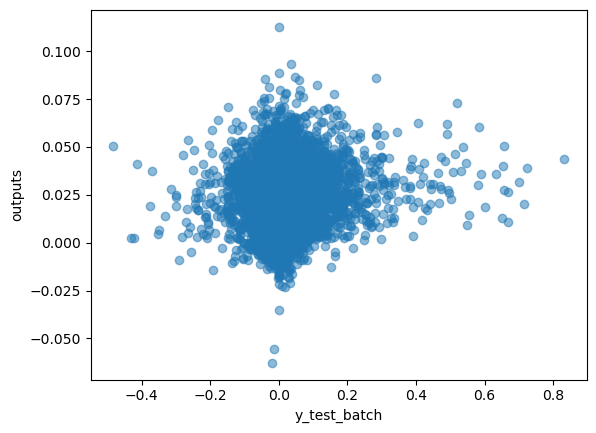

In [24]:
# plot the y_test_batch versus the outputs
plt.scatter(y_test_batch, outputs, alpha=0.5)
plt.xlabel("y_test_batch")
plt.ylabel("outputs")

In [26]:
from sklearn.metrics import r2_score

# compute R2
r2_score(y_test_batch, outputs)

0.012698254529006192

In [27]:
# compute the MSE
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test_batch, outputs, squared=False)

0.06011853

In [29]:
# normalize outputs
mean = outputs.mean()
std = outputs.std()
outputs_norm = (outputs - mean) / std


outputs_norm = (outputs - outputs.min()) / (outputs.max() - outputs.min()).item()

Text(0, 0.5, 'outputs normalized')

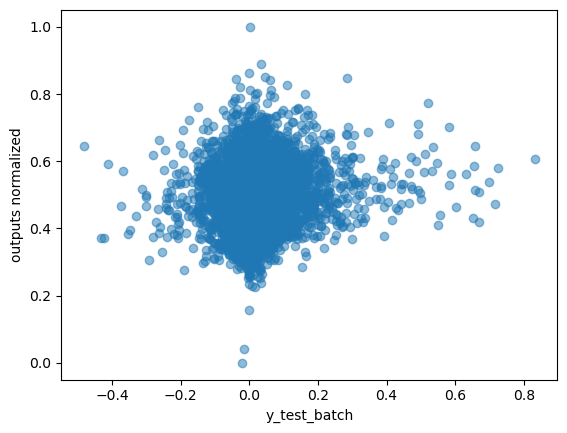

In [30]:
# plot the y_test_batch versus the outputs
plt.figure()
plt.scatter(y_test_batch, outputs_norm, alpha=0.5)
plt.xlabel("y_test_batch")
plt.ylabel("outputs normalized")

In [33]:
r2_score(outputs_norm, y_test_batch)

-27.299570684533357

In [ ]:
import numpy as np
a = np.array(outputs_norm)
a.min()

0.0

In [34]:
outputs

tensor([[0.0129],
        [0.0166],
        [0.0017],
        ...,
        [0.0180],
        [0.0137],
        [0.0034]])

In [ ]:
a = np.array(y_test_batch)
a.min()

-0.48666668

In [ ]:
a.max()

0.80833334